In [1]:
import sys
sys.path.append('/home/simone/Desktop/NLFF/Experiments/cumulativeReturnPeper')
from technicalSignals import Indicators
import pickle



import backtrader as bt
import backtrader.indicators as btind
import numpy as np
from sklearn.metrics import confusion_matrix
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import pandas as pd
import math
from sklearn import preprocessing
from math import sqrt


In [2]:
tickers=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX']
TREND_WINDOWs = [(1,2),(1,8),(1,29),(1,36),(1,50)]
TREND_WINDOWs = [(1,50)]
kind_of_dataset = 'AffectiveSpace'
NN_INPUT_DIM = 717

In [3]:
class DatasetManager:
    def __init__(self):
        X_raw = None
        Y_raw = None
        Y = None
        X = None
        cum_ret_test = None
    
    def load_dataset(self, ticker, kind, technicalFeatures=False):
        types = {'Summary': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/',
            'AffectiveSpace': '/home/simone/Desktop/NLFF/AffectiveSpace/Aggregated_AffectSummary_dataset/',
            'Title': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentTitleAggregatedHourly/',
            'Senticnet':''}
        news =  pd.read_csv(types[kind]+ticker+'.csv')
        price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv')
        price = price.rename(index=str, columns={"date": "DATE"})
        news = news.rename(index=str, columns={"initTime": "DATE"})
        news = news.drop(['Unnamed: 0'], axis=1)
        news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
        # This datased is already GMT+0
        price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
        if(technicalFeatures):
            price['mom_30'] = Indicators.momentum(price, 30)
            price['mom_50'] = Indicators.momentum(price, 50)
            price['mom_100'] = Indicators.momentum(price, 100)
            price['mom_150'] = Indicators.momentum(price, 150)
            price['SMA_30'] = Indicators.SMA(price, 30)
            price['SMA_50'] = Indicators.SMA(price, 50)
            price['SMA_100'] = Indicators.SMA(price, 100)
            price['SMA_150'] = Indicators.SMA(price, 150)
            price['in_BBands'] = Indicators.inBBands(price)
            price['eccessVolumes'] = Indicators.eccessOfVolumes(price)


        #ALLIGNMENT
        initDate = max(news['DATE'][0], datetime(2017, 5, 22, 0, 0, 0))
        finalDate = min(news['DATE'][len(news)-1],datetime(2018, 6, 21, 0, 0, 0))
        news.drop(news[news.DATE > finalDate].index, inplace=True)
        news.drop(news[news.DATE < initDate].index, inplace=True)
        news = news.reset_index(drop=True)
        price.drop(price[price.DATE > finalDate].index, inplace=True)
        price.drop(price[price.DATE < initDate].index, inplace=True)
        price = price.reset_index(drop=True)
        assert len(price) == len(news)
        # FEATURES
        sentiment = news.drop(['DATE'], axis=1)
        X = sentiment
        for window in [5,10,15,20,30,50]:
            temp = sentiment.rolling(window).mean()
            temp.columns = temp.columns +'_'+str(window)
            X = pd.concat([X, temp],axis=1)
        if(technicalFeatures):   
            technical_features = ['mom_30','mom_50','mom_100','mom_150',
                      'SMA_30','SMA_50','SMA_100','SMA_150',
                      'in_BBands', 'eccessVolumes']
            X = pd.concat([X, price[technical_features]],axis=1)

            
        #NORMALIZATION:
        min_max_scaler = preprocessing.MinMaxScaler()
        X = np.nan_to_num(np.asarray(X, dtype=float))
        X = np.asarray(min_max_scaler.fit_transform(X))
        self.X_raw = X
        self.Y_raw = price

    def get_dataset_for_trend(self, init, finish, perc_train = 0.7):
        y = list()
        x = list()
        dates = list()
        price = self.Y_raw
        self.cum_ret_test = []
        for i in range(abs(init),len(price)-finish):
            cumulative_return =  (price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
            y.append(0 if cumulative_return<0 else 1)
            dates.append(price.iloc[i]['DATE'])
            x.append(self.X_raw[i])
            self.cum_ret_test.append(cumulative_return)
        
       #y = self.normalize(np.array(y))
        y = np.array(y)
        x = np.array(x)
        self.X = x
        self.Y = y
        nt=math.ceil(len(x)*perc_train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        self.cum_ret_test = self.cum_ret_test[nt:]
        dates_test = dates[nt:]
        return (x_tv,y_tv),(x_test,y_test),dates_test

In [4]:
# ===========================================    Trading Library utilities

    
class Sizer(bt.Sizer):
    params = dict(stake=1)

    def _getsizing(self, comminfo, cash, data, isbuy):
        dt, i = self.strategy.datetime.date(), data._id
        s = self.p.stake * (1 + (not isbuy))
        print('{} Data {} OType {} Sizing to {}'.format(
            dt, data._name, ('buy' * isbuy) or 'sell', s))

        return 10

    
class Strategy(bt.Strategy):
    params = dict(
        pred_threshold = None,        #buy if prediction more than this threshold (prediction values normalized 1: most secure prediction)
        forecast_window = None,
        predictions = None,
        verbose = None,
        norm = None,
        overlapping_steps = None
    )

    def log(self, txt, dt=None):
        dt = dt or self.datetime.datetime().strftime('%Y-%m-%d %H:%M:%S')
        print('%s, %s' % (dt, txt))

    def notify_order(self, order):
            if order.status in [order.Submitted, order.Accepted]:
                return
            if order.status in [order.Completed]:
                if order.isbuy() and self.verbose > 1:
                    self.log('BUY EXECUTED, %.2f' % order.executed.price)
                elif order.issell() and self.verbose > 1:
                    self.log('SELL EXECUTED, %.2f' % order.executed.price)
            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log('\n\nOrder Canceled/Margin/Rejected\n\n')
                #assert False

        
    def __init__(self):
        self.planned_sell = {}  # PLANNED SELL FOR EACH BUY AFTER TREND WINDOW dict: selldate, stock -> amount
        self.forecast_window = self.params.forecast_window
        self.predictions = self.params.predictions
        self.pred_threshold = self.params.pred_threshold
        self.verbose = self.params.verbose
        self.norm = self.params.norm
        self.overlapping_steps = self.params.overlapping_steps 
        

    def next(self):
        #Our investments are overlapped over steps. each step we can invest 1/#overlapped_steps money
        investment_this_step = self.broker._value/self.overlapping_steps 
        positions = {}
        # Count how many trades on this step
        n_trades = 0
        for i, d in enumerate(self.datas):
            dt = self.datetime.datetime().strftime('%Y-%m-%d %H:%M:%S')
            dn = d._name
            ticker_pred = self.predictions[dn].at[dt] if self.norm else self.predictions[dn].at[dt]
            if(abs(ticker_pred)>self.pred_threshold):
                n_trades +=1
        trade_perc = 1 if n_trades == 0 else 1/n_trades
        
        for i, d in enumerate(self.datas):
            dt = self.datetime.datetime().strftime('%Y-%m-%d %H:%M:%S')
            time_idx = np.where(self.predictions.index==dt)[0][0]
            dn = d._name
            ticker_pred = self.predictions[dn].at[dt] if self.norm else self.predictions[dn].at[dt]
            pos = self.getposition(d).size
            positions[dn]=pos
            stock_price = d.tick_close
            # Strategy: trade if abs(pred)> threshold
            #if(abs(ticker_pred)>self.pred_threshold):
            if(abs(ticker_pred)>self.pred_threshold and stock_price != None): #I'm not able to trade last tick, close price = None
                # Buy and set planned sell if prediction positive
                stock_number = math.floor(trade_perc * investment_this_step / stock_price)
                if(ticker_pred > 0):
                    self.buy(data = d, size=stock_number)                
                    idx_to_sell = time_idx+self.forecast_window
                    self.planned_sell[(dn,idx_to_sell)] = stock_number
                else:
                    self.sell(data = d, size=stock_number)                
                    idx_to_sell = time_idx+self.forecast_window
                    self.planned_sell[(dn,idx_to_sell)] = -stock_number
                    
            #Execute sell planned for now
            if (dn,time_idx) in self.planned_sell:
                amount = self.planned_sell[(dn,time_idx)]
                if(amount>0):
                    self.sell(data = d, size=amount)
                else:
                    self.buy(data = d, size=amount)
                del self.planned_sell[(dn,time_idx)] 
        if self.verbose > 0:
                print('{} Positions {}'.format(dt, positions))

                
                
                
def printTradeAnalysis(analyzer):
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lose_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total,2)
    strike_rate = (total_won / total_closed) * 100
    h1 = ['Total Open', 'Total Closed', 'Total Won', 'Total Lost']
    h2 = ['Strike Rate','Win Streak', 'Losing Streak', 'PnL Net']
    r1 = [total_open, total_closed,total_won,total_lost]
    r2 = [strike_rate, win_streak, lose_streak, pnl_net]
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("Trade Analysis Results:")
    for row in print_list:
        print(row_format.format('',*row))
    return strike_rate

def printSQN(analyzer):
    sqn = round(analyzer.sqn,2)
    print('SQN: {}'.format(sqn))

def get_hist_broker(strategy):
    i=1
    portfolioValue = []
    cash = []
    while not np.isnan(strategy.stats.broker.value.array[i]):
        portfolioValue.append(strategy.stats.broker.value.array[i])
        cash.append(strategy.stats.broker.cash.array[i])
        i += 1
    return (np.asarray(portfolioValue),np.asarray(cash))


def get_drawDown(strategy):
    maxMoneyDown = strategy.analyzers.drawdown.get_analysis()['max']['moneydown']
    maxPercDown = strategy.analyzers.drawdown.get_analysis()['max']['drawdown']
    maxLenDown = strategy.analyzers.drawdown.get_analysis()['max']['len']
    return (maxPercDown, maxMoneyDown, maxLenDown)

def compute_SharpeRatio(strategy):
    (portfolioValue, cash) = get_hist_broker(strategy)
    returns = np.asarray(list(strategy.analyzers.returns.get_analysis().values()))*portfolioValue[0]/max(portfolioValue-cash)
    sharpe = (np.mean(returns) - RISK_FREE_RATE_HOURLY )/np.std(returns)
    sharpe = sharpe*math.sqrt(TRADING_HOURS_PER_YEAR) #Transfrom in annual measure
    return sharpe



====================  trend:  1   50  threshold:  0.0  ==================== 

Starting Portfolio Value: 1000000.00
Trade Analysis Results:
               Total Open     Total Closed   Total Won      Total Lost     
               10             50             30             30             
               Strike Rate    Win Streak     Losing Streak  PnL Net        
               60.0           4              4              63161.73       
SQN: 2.84
Final Portfolio Value: 1067752.36 
Gain: 0.07
Annualized Gain:  0.23212134869659806
Max  DrawDown:  0.04396142786866343
Sharpe:  2.8703178933518156


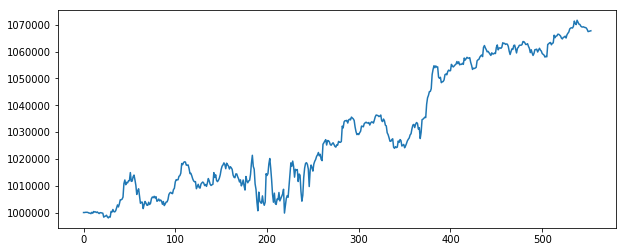


====================  trend:  1   50  threshold:  0.2  ==================== 

Starting Portfolio Value: 1000000.00
Trade Analysis Results:
               Total Open     Total Closed   Total Won      Total Lost     
               7              38             21             21             
               Strike Rate    Win Streak     Losing Streak  PnL Net        
               55.263157894736855              5              59074.98       
SQN: 2.12
Final Portfolio Value: 1102654.76 
Gain: 0.10
Annualized Gain:  0.3649993618374161
Max  DrawDown:  0.0562618503286034
Sharpe:  2.244931986500667


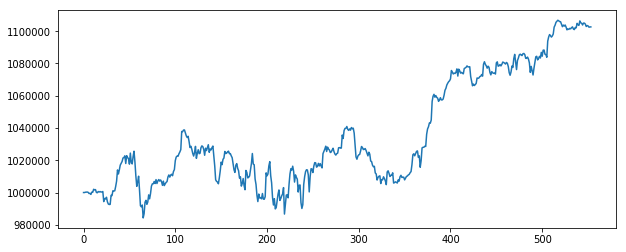


====================  trend:  1   50  threshold:  0.4  ==================== 

Starting Portfolio Value: 1000000.00
2018-04-06 20:00:00, 

Order Canceled/Margin/Rejected


2018-04-06 20:00:00, 

Order Canceled/Margin/Rejected


2018-04-09 17:00:00, 

Order Canceled/Margin/Rejected


Trade Analysis Results:
               Total Open     Total Closed   Total Won      Total Lost     
               4              25             17             17             
               Strike Rate    Win Streak     Losing Streak  PnL Net        
               68.0           8              8              116586.26      
SQN: 2.62
Final Portfolio Value: 1141975.72 
Gain: 0.14
Annualized Gain:  0.5261110359438881
Max  DrawDown:  0.049530956830595926
Sharpe:  2.5333856281354006


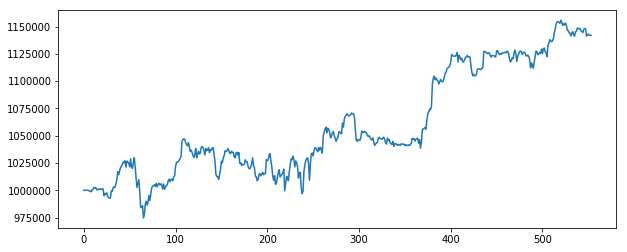


====================  trend:  1   50  threshold:  0.6  ==================== 

Starting Portfolio Value: 1000000.00
2018-05-25 17:00:00, 

Order Canceled/Margin/Rejected


2018-05-25 17:00:00, 

Order Canceled/Margin/Rejected


2018-05-25 18:00:00, 

Order Canceled/Margin/Rejected


Trade Analysis Results:
               Total Open     Total Closed   Total Won      Total Lost     
               3              15             9              9              
               Strike Rate    Win Streak     Losing Streak  PnL Net        
               60.0           4              4              103206.44      
SQN: 2.35
Final Portfolio Value: 1141909.77 
Gain: 0.14
Annualized Gain:  0.5258304440109007
Max  DrawDown:  0.041960599645891786
Sharpe:  2.7198123142401145


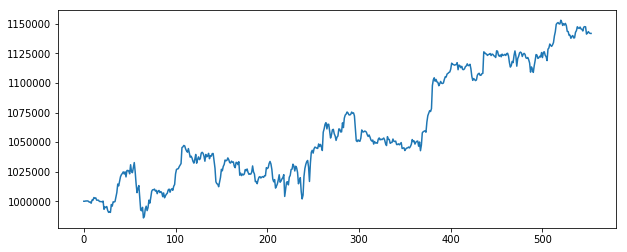


====================  trend:  1   50  threshold:  0.8  ==================== 

Starting Portfolio Value: 1000000.00
2018-05-25 19:00:00, 

Order Canceled/Margin/Rejected


Trade Analysis Results:
               Total Open     Total Closed   Total Won      Total Lost     
               2              12             9              9              
               Strike Rate    Win Streak     Losing Streak  PnL Net        
               75.0           6              6              88245.92       
SQN: 2.01
Final Portfolio Value: 1135086.14 
Gain: 0.14
Annualized Gain:  0.49698732207187546
Max  DrawDown:  0.034526575241760095
Sharpe:  3.186458871294397


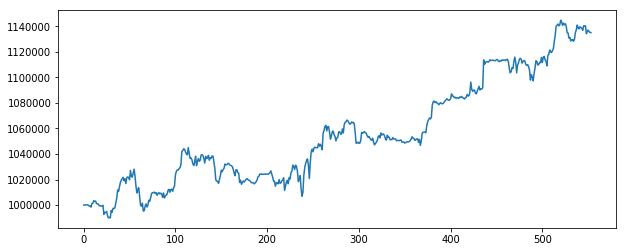

In [5]:
TRADING_HOURS_PER_YEAR = 252*7
RISK_FREE_RATE_HOURLY = 0.0174 / TRADING_HOURS_PER_YEAR
init_value = 1000000.0
MOVING_AVG_WINDOW = 3
SHARPEs = np.zeros([len(TREND_WINDOWs), 5])
STRIKE_RATEs = np.zeros([len(TREND_WINDOWs), 5])
GAINSs = np.zeros([len(TREND_WINDOWs), 5])
DRAWDOWNs = np.zeros([len(TREND_WINDOWs), 5])
PortfolioHistorys = [[0 for _ in range(0,5)] for _ in range(len(TREND_WINDOWs))]

for (init, finish) in TREND_WINDOWs:
    predictions = pd.read_csv('test_predictions/AllTickers_'+str(init)+'_'+str(finish)+'.csv', index_col = 0)
    predictions = predictions.rolling(window=MOVING_AVG_WINDOW).mean().fillna(0)
    #Set threshold according to the mean of the max prediction
    meanMax = 0
    for ticker in tickers:
        meanMax += predictions[ticker].abs().max()/len(tickers)
    thresholds = np.linspace(0, meanMax, num=6)[:-1]
    dates_test = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in predictions.index]
    for t in range(0,5):
        print('\n====================  trend: ',init,' ',finish, ' threshold: ',t/5 ,' ==================== \n')
        #cerebro = bt.Cerebro(stdstats=False) #Plot pulito
        cerebro = bt.Cerebro()
        cerebro.addobservermulti(bt.observers.BuySell)
        cerebro.broker.setcash(init_value)
        cerebro.broker.setcommission(commission=0.0001)
        #cerebro.broker.setcommission(commission=0)
        pred_threshold = thresholds[t]
        for ticker in tickers:
            data = bt.feeds.GenericCSVData(
                        dataname='/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv',
                        name=ticker,
                        timeframe = bt.TimeFrame.Minutes, 
                        compression = 60,
                        datetime=1,open=2,high=3,low=4,close=5,volume=6,openinterest=-1,
                        fromdate=dates_test[0],
                        todate=dates_test[-1]+timedelta(minutes=1),
                        reverse=False)
            cerebro.adddata(data)

        cerebro.addsizer(Sizer)    
        assert init == 1 #Up to now only future
        cerebro.addstrategy(Strategy,
                            pred_threshold = pred_threshold,
                            forecast_window=finish,
                            predictions = predictions,
                            verbose = 0,
                            norm = False,
                            overlapping_steps = finish-init)
        cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
        cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
        cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annRet")
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")
        cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='returns')
        
        print('Starting Portfolio Value: %.2f' % init_value)
        strategy = cerebro.run()[0]
        final_value = cerebro.broker.getvalue()
        strike_rate = printTradeAnalysis(strategy.analyzers.ta.get_analysis())
        #print('Annual Return: ',strategy.analyzers.annRet.get_analysis()[2018])
        printSQN(strategy.analyzers.sqn.get_analysis())
        print('Final Portfolio Value: %.2f \nGain: %.2f' % (final_value, final_value/init_value - 1))
        (portfolioValue, cash) = get_hist_broker(strategy)
        #real gain Computed considered as amount of money only the max requested to run the strategy
        # real_gain = (final_value - init_value)/max(portfolioValue-cash) 
        real_gain = final_value/init_value - 1        
        annualized_gain = (1+real_gain)**(TRADING_HOURS_PER_YEAR/len(portfolioValue))-1
        
        drawDownPerc = get_drawDown(strategy)[1]/max(portfolioValue-cash) 
        sharpe = compute_SharpeRatio(strategy)
        print('Annualized Gain: ', annualized_gain)
        print('Max  DrawDown: ', drawDownPerc)
        print('Sharpe: ', sharpe)
        plt.figure(figsize=(10,4))
        plt.plot(portfolioValue)
        plt.show()
        
        SHARPEs[TREND_WINDOWs.index((init, finish)), t] = sharpe
        GAINSs[TREND_WINDOWs.index((init, finish)), t] = annualized_gain
        PortfolioHistorys[TREND_WINDOWs.index((init, finish))][t] =  list(portfolioValue)
        DRAWDOWNs[TREND_WINDOWs.index((init, finish)), t] = drawDownPerc
        STRIKE_RATEs[TREND_WINDOWs.index((init, finish)), t] = strike_rate
        
np.savetxt('SHARPEs_percentile_on_predictions.csv', SHARPEs, delimiter=",")
np.savetxt('GAINSs_percentile_on_predictions.csv', GAINSs, delimiter=",")
np.savetxt('DRAWDOWNs_percentile_on_predictions.csv', DRAWDOWNs, delimiter=",")
np.savetxt('STRIKE_RATEs_percentile_on_predictions.csv', STRIKE_RATEs, delimiter=",")
with open('PortfolioHistorys_percentile_on_predictions.pickle', 'wb') as handle:
        pickle.dump(PortfolioHistorys, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# cerebro.plot(volume=False)

In [7]:
# ## MARKET PERFORMANCE:
# class BuyAndHold(bt.Strategy):
#     def log(self, txt, dt=None):
#         dt = dt or self.datetime.datetime().strftime('%Y-%m-%d %H:%M:%S')
#         #print('%s, %s' % (dt, txt))

#     def notify_order(self, order):
#         if order.status in [order.Submitted, order.Accepted]:
#             return
#         if order.status in [order.Completed]:
#             if order.isbuy():
#                 self.log('BUY EXECUTED, %.2f' % order.executed.price)
#             elif order.issell():
#                 self.log('SELL EXECUTED, %.2f' % order.executed.price)
      
#     def __init__(self):
#         return

#     def next(self): 
#         for i, d in enumerate(self.datas):
#             self.buy(data = d, size=1)                


# init_value = 3670.0 #Correct value to buy one stock a the beginning
# init_value = 100000

# for (init, finish) in TREND_WINDOWs:
#     print('\n====================  trend: ',init,' ',finish, ' ==================== \n')
#     cerebro = bt.Cerebro()
#     cerebro.broker.setcash(init_value)
#     cerebro.broker.setcommission(commission=0.0001)
#     predictions = pd.read_csv('test_predictions/AllTickers_'+str(init)+'_'+str(finish)+'.csv', index_col = 0)
#     dates_test = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in predictions.index]
#     for ticker in tickers:
#         data = bt.feeds.GenericCSVData(
#                     dataname='/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv',
#                     name=ticker,
#                     timeframe = bt.TimeFrame.Minutes, 
#                     compression = 60,
#                     datetime=1,open=2,high=3,low=4,close=5,volume=6,openinterest=-1,
#                     fromdate=dates_test[0],
#                     todate=dates_test[-1]+timedelta(minutes=1),
#                     reverse=False)
#         cerebro.adddata(data)
        
#     cerebro.addstrategy(BuyAndHold)
#     cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
#     print('Starting Portfolio Value: %.2f' % init_value)
#     strategy = cerebro.run()[0]
#     final_value = cerebro.broker.getvalue()
#     print('Final Portfolio Value: %.2f \nGain: %.2f' % (final_value, final_value/init_value - 1))

In [8]:
#max(abs(portfolioValue-cash))
# /!\ Cash puo' essere maggiore di portfolio value
# sebbene portfolio value = cash + value stocks
# -> value stocks negativo

In [9]:
(final_value - init_value)

135086.1399763683